# Offline Plotting Tutorial

The new dataset comes with a tool for offline (i.e. not live as the data are coming in) plotting. This notebook explains how to use it and what it is capable of plotting.

The tool in question is the function `plot_by_id`.

In [1]:
%matplotlib notebook
import numpy as np

import qcodes as qc

from typing import List, Dict, Tuple, Any
import matplotlib.pyplot as plt
import qcodes as qc
from qcodes import ParamSpec, new_data_set, new_experiment
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.database import initialise_database

First we make an experimental run, so that we have something to plot.

In [2]:
# if you just deleted your database file, you'll need to init a new one
initialise_database()

In [3]:
new_experiment('test_plot_by_id', 'nosample')

test_plot_by_id#nosample#39@C:\Users\a-miasta/experiments.db
------------------------------------------------------------

In [4]:
# Make a handful of parameters to be used in the examples

x = ParamSpec('x', 'numeric', label='Voltage', unit='V')
t = ParamSpec('t', 'numeric', label='Time', unit='s')
y = ParamSpec('y', 'numeric', label='Voltage', unit='V', depends_on=[x])
y2 = ParamSpec('y2', 'numeric', label='Current', unit='A', depends_on=[x])
z = ParamSpec('z', 'numeric', label='Majorana number', unit='Anyon', depends_on=[x, t])

## A single, simple 1D sweep

In [5]:
data_set = new_data_set('1D-sweep')

data_set.add_parameter(x)
data_set.add_parameter(y)

In [6]:
%%time
xvals = np.linspace(-3.4, 4.2, 250)

for xnum in xvals:
    noise = np.random.randn()*0.1  # multiplicative noise yeah yeah
    data_set.add_result({'x': xnum, 'y': 2*(xnum+noise)**3 - 5*(xnum+noise)**2})

data_set.mark_complete()

Wall time: 4.93 s


Now let us plot that run. The function `plot_by_id` takes the `run_id` of the run to plot as a positional argument. Furthermore, the user may specify the matplotlib axis object (or list of axis objects) to plot on.

If no axes are specified, the function creates new axis object(s). The function returns a tuple of a list of the axes and a list of the colorbar axes (just `None`s if there are no colorbars).

<IPython.core.display.Javascript object>


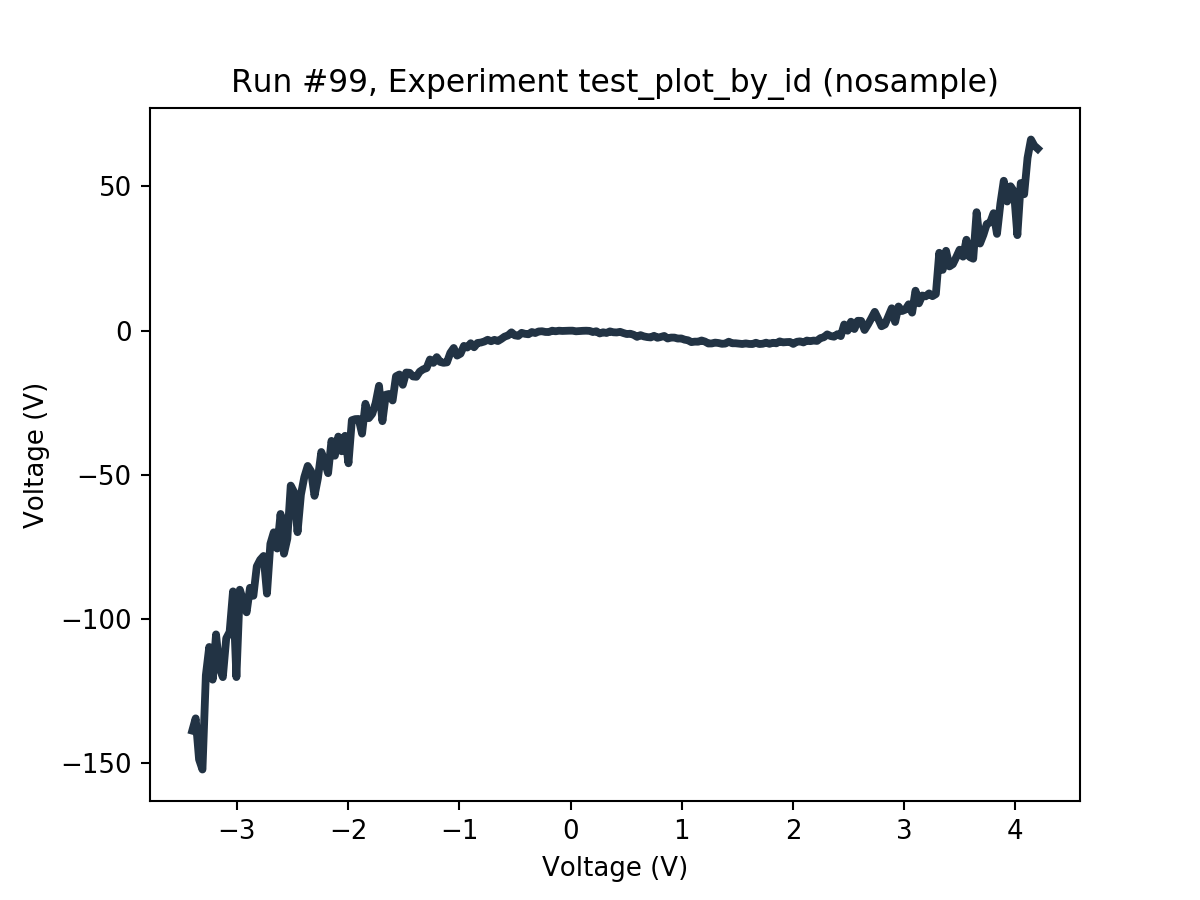

In [7]:
axes, cbaxes = plot_by_id(data_set.run_id)

Using the returned axis, we can e.g. change the plot linewidth and color. We refer to the matplotlib documentation for details on matplotlib plot customization.

In [9]:
my_ax = axes[0]
line = my_ax.lines[0]
line.set_color('#223344')
line.set_linewidth(3)

## Two interleaved 1D sweeps

Now we make a run where two parameters are measured as a function of the same parameter.

In [10]:
data_set = new_data_set('interleaved-1Ds')

In [11]:
data_set.add_parameter(x)
data_set.add_parameter(y)
data_set.add_parameter(y2)

In [12]:
xvals = np.linspace(-5, 5, 250)

for xnum in xvals:
    data_set.add_result({'x': xnum, 'y': xnum**2})
    data_set.add_result({'x': xnum, 'y2': -xnum**2})
data_set.mark_complete()

In such a situation, `plot_by_id` by default creates a new axis for **each** dependent parameter. Sometimes this is not desirable; we'd rather have both plots on the same axis. In such a case, we might pass the same axis twice to `plot_by_id`.

<IPython.core.display.Javascript object>


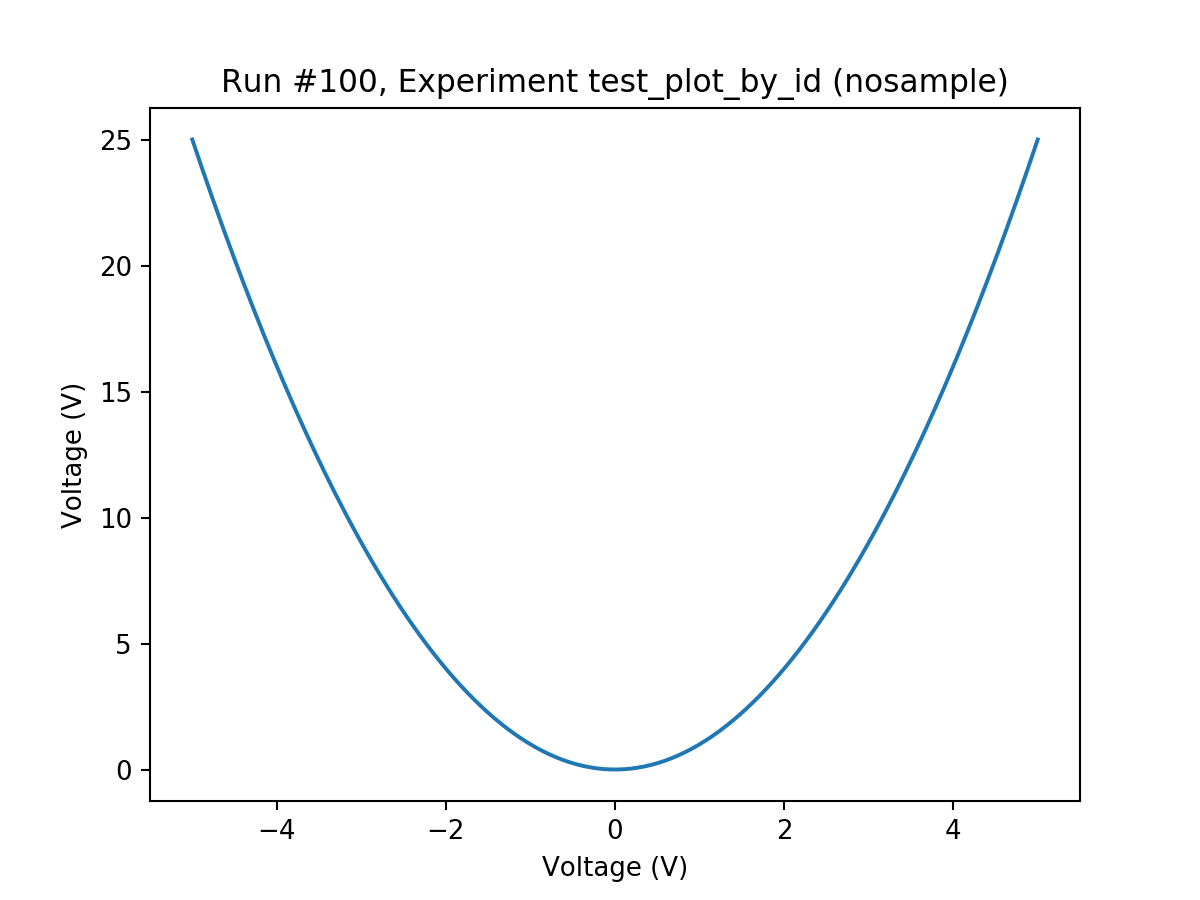

<IPython.core.display.Javascript object>


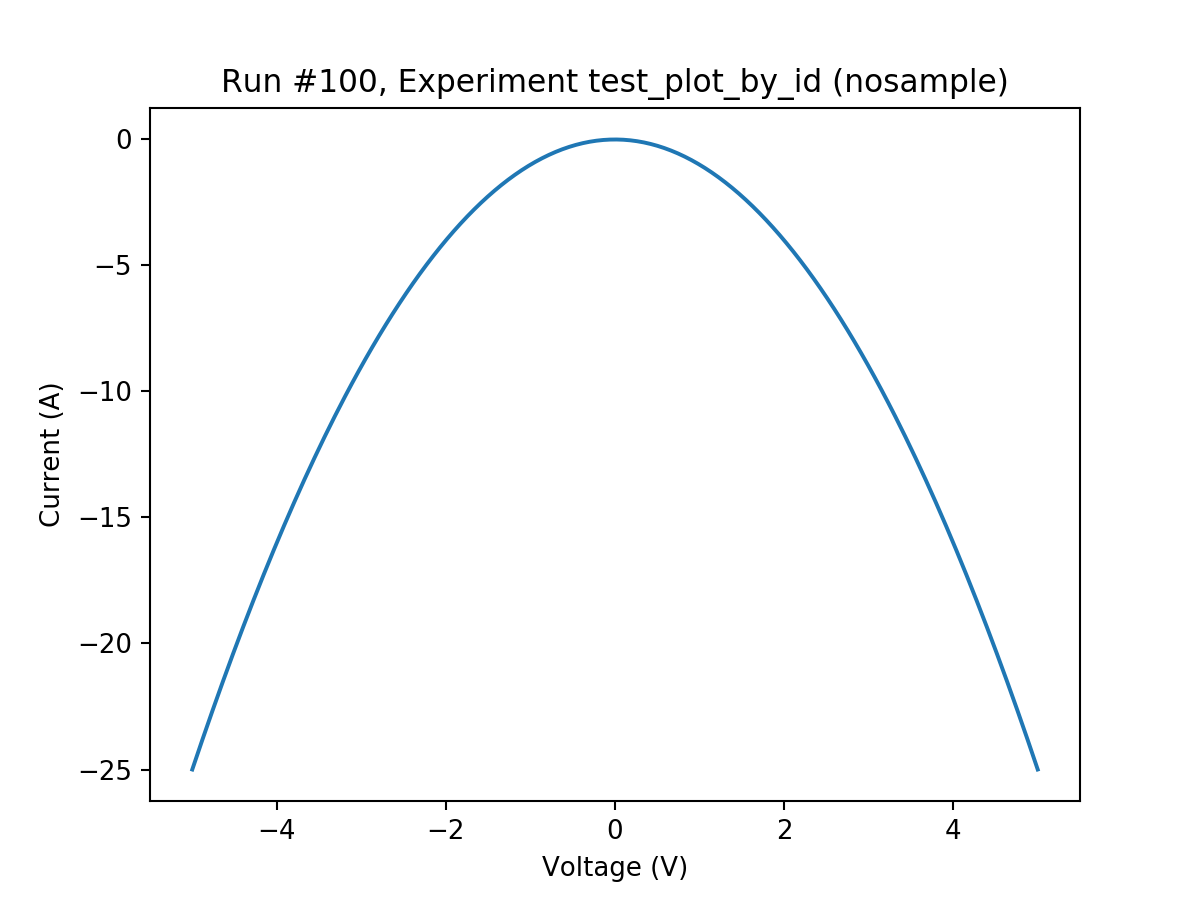

In [13]:
axes, cbaxes = plot_by_id(data_set.run_id)

Let's do that now

<IPython.core.display.Javascript object>


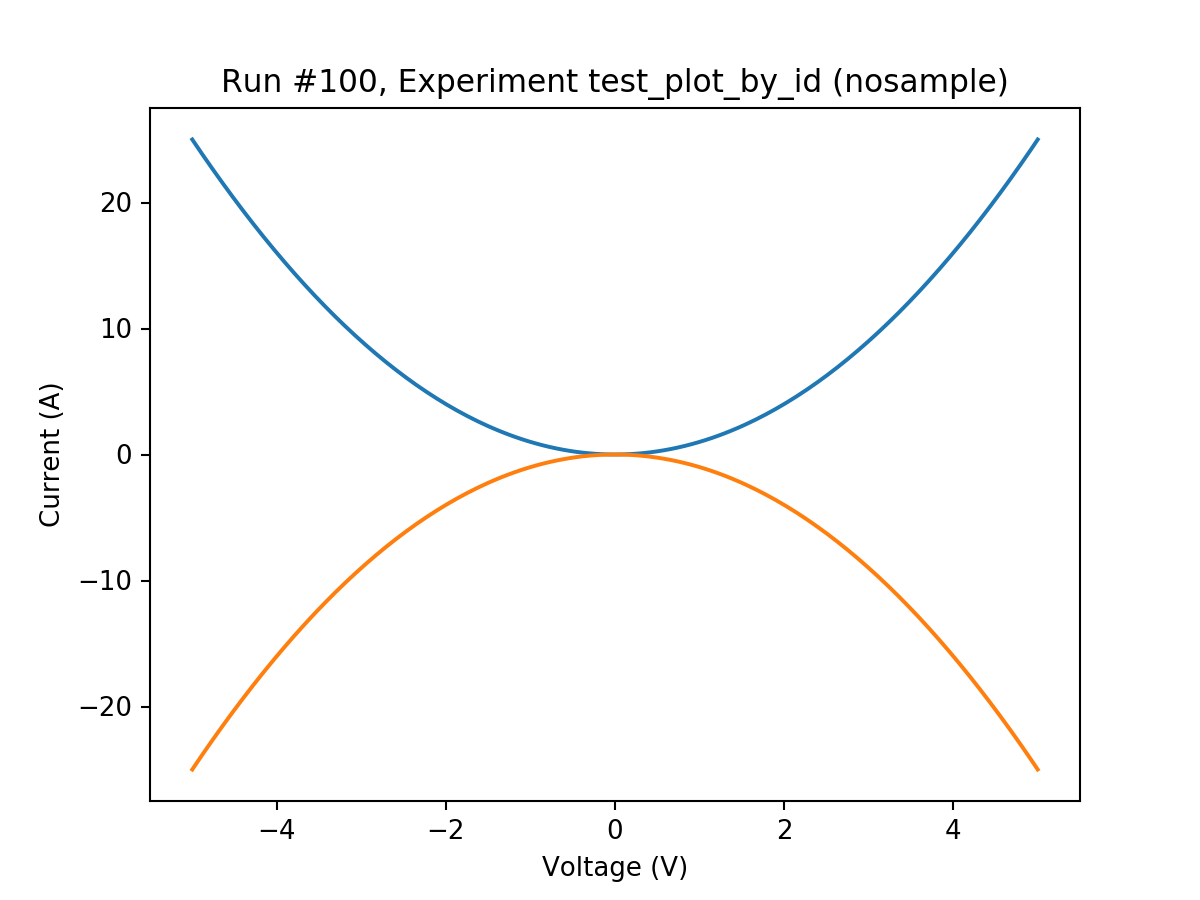

In [14]:
fig, ax = plt.subplots(1)
axes, cbaxes = plot_by_id(data_set.run_id, axes=[ax, ax])

## Regular 2D rectangular sweep scan

For 2D plots, a colorbar is usually present. As mentioned above, `plot_by_id` returns this.

In [15]:
data_set = new_data_set('regular-2D-scan')
data_set.add_parameter(x)
data_set.add_parameter(t)
data_set.add_parameter(z)

In [16]:
xvals = np.linspace(-4, 5, 50)
tvals = np.linspace(-500, 1500, 25)

for xv in xvals:
    for tv in tvals:
        # just some arbitrary semi good looking function
        zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
        data_set.add_result({'x': xv, 't': tv, 'z': zv})

data_set.mark_complete()

<IPython.core.display.Javascript object>


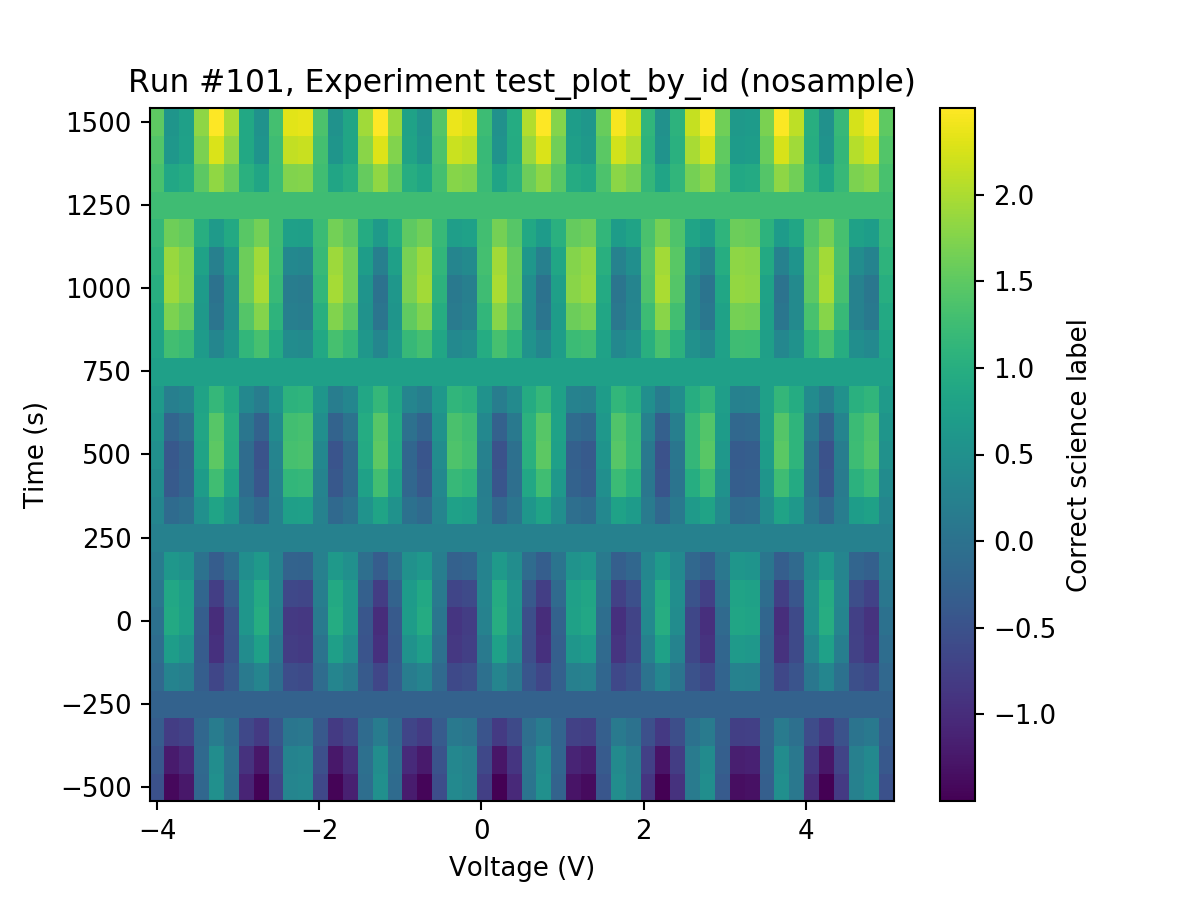

In [17]:
axes, colorbars = plot_by_id(data_set.run_id)

A somewhat normal situation is that the colorbar was somehow mislabelled. Using the returned colorbar, the label can be overwritten.

In [18]:
colorbar = colorbars[0]
colorbar.set_label('Correct science label')

## Warped 2D rectangular sweep scan

A nice feature of the new dataset is that the grid may be warped; it makes no difference.
Here we warp the x axis of the previous scan to increase the resolution in the right half plane.

In [19]:
data_set = new_data_set('warped-2D-scan')
data_set.add_parameter(x)
data_set.add_parameter(t)
data_set.add_parameter(z)

In [20]:
xvals = np.linspace(-4, 5, 50) + np.cos(2/9*np.pi*xvals+np.pi/4)
tvals = np.linspace(-500, 1500, 25)


for xv in xvals:
    for tv in tvals:
        # just some arbitrary semi good looking function
        zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
        data_set.add_result({'x': xv, 't': tv, 'z': zv})

data_set.mark_complete()

<IPython.core.display.Javascript object>


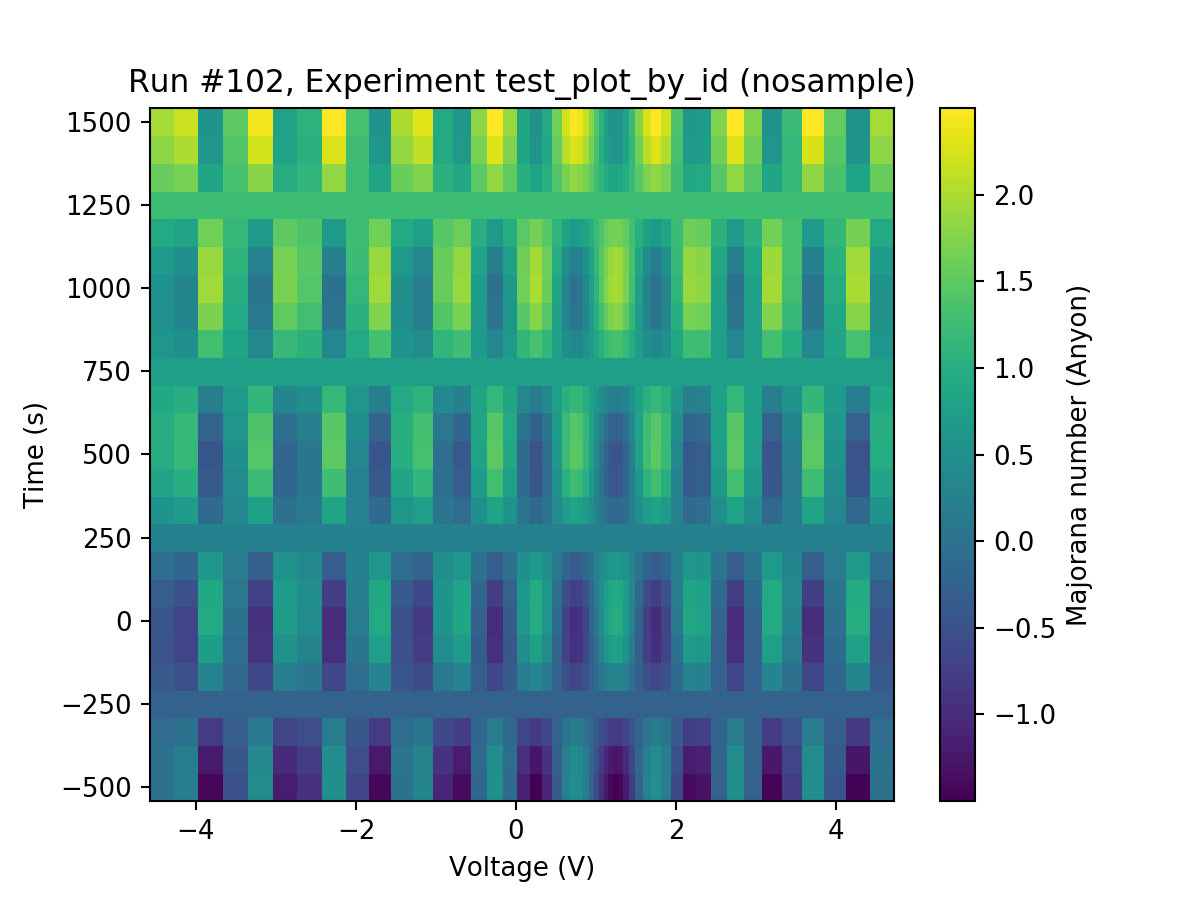

In [21]:
axes, cbaxes = plot_by_id(data_set.run_id)

## Interrupted 2D scans (a hole in the cheese)

In case a sweep in interrupted, the entire grid will not be filled out. This is also supported,
in fact, any single rectangular hole is allowed

In [22]:
data_set = new_data_set('warped-with-hole-2D-scan')
data_set.add_parameter(x)
data_set.add_parameter(t)
data_set.add_parameter(z)

In [23]:
xvals = np.linspace(-4, 5, 50) + np.cos(2/9*np.pi*xvals+np.pi/4)
tvals = np.linspace(-500, 1500, 25)


# define two small forbidden range functions
def no_x(xv):
    if xv > 0 and xv < 3:
        return True
    else:
        return False
    
def no_t(tv):
    if tv > 0 and tv < 450:
        return True
    else:
        return False

for xv in xvals:
    for tv in tvals:
        if  no_x(xv) and no_t(tv):
            continue
        else:
            # just some arbitrary semi good looking function
            zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            data_set.add_result({'x': xv, 't': tv, 'z': zv})

data_set.mark_complete()

<IPython.core.display.Javascript object>


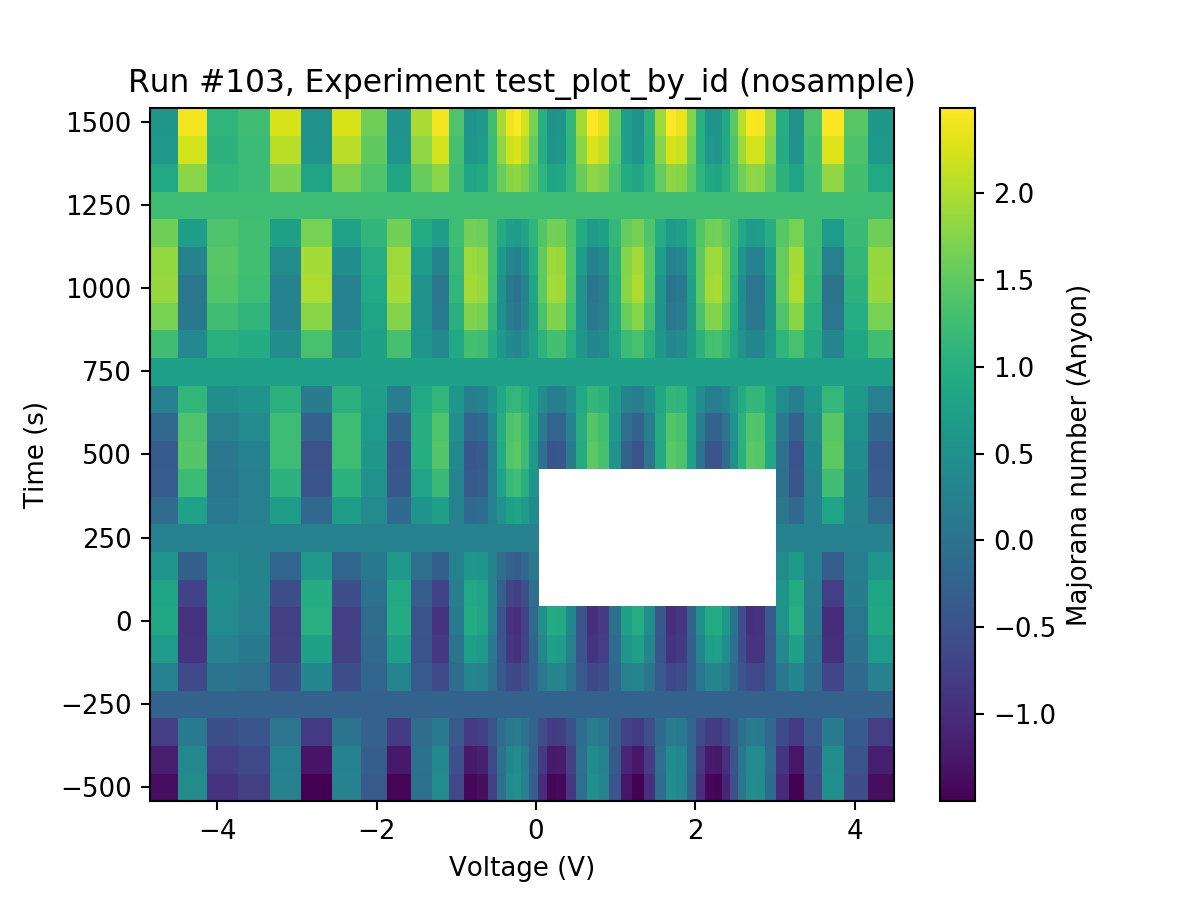

In [24]:
axes, colorbars = plot_by_id(data_set.run_id)

## Fancy plotting

As a final example, let us combine several plots in one window.

We first make a little grid of axes.

<IPython.core.display.Javascript object>


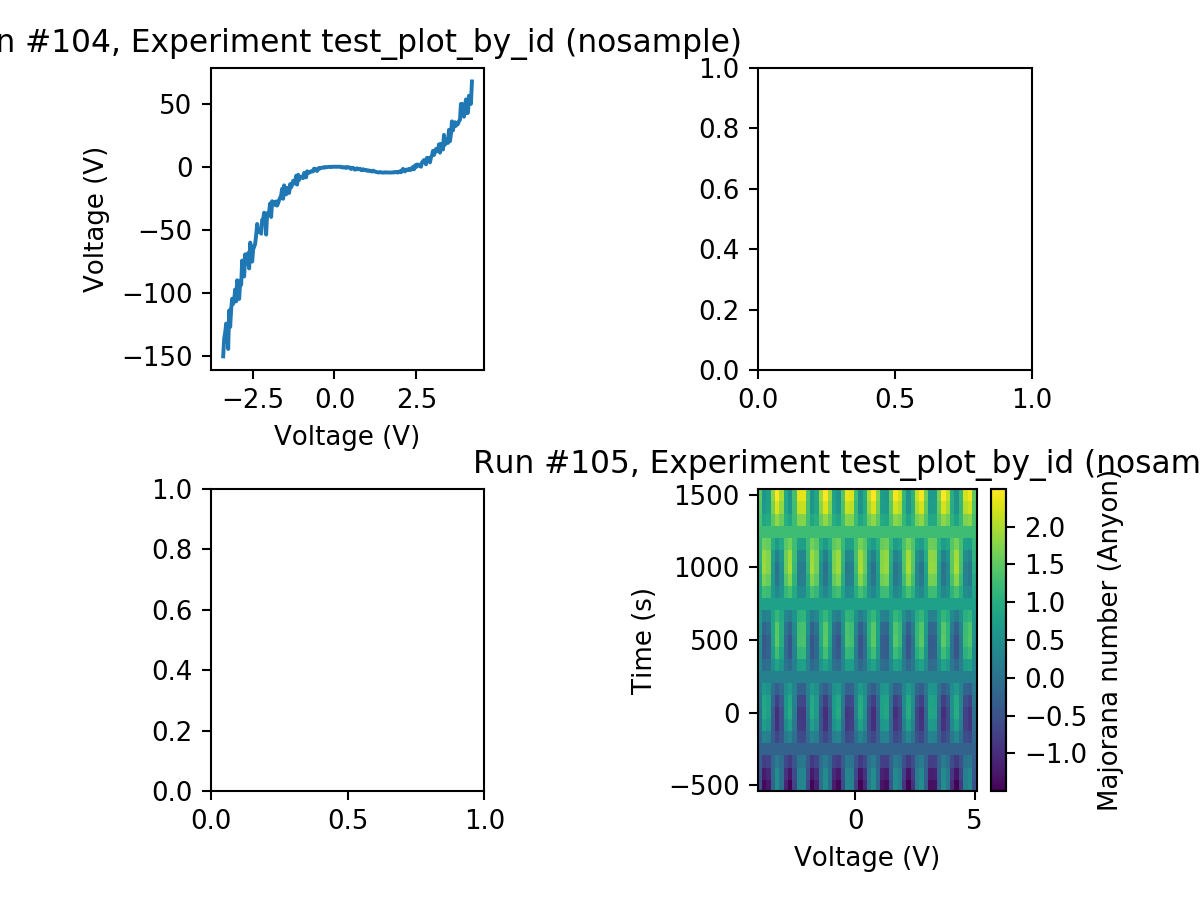

In [25]:
fig, figaxes = plt.subplots(2, 2)

Next, we make some runs (shamelessly copy-pasting from above).

In [26]:
# First run

data_set = new_data_set('1D-sweep')

data_set.add_parameter(x)
data_set.add_parameter(y)

xvals = np.linspace(-3.4, 4.2, 250)

for xnum in xvals:
    noise = np.random.randn()*0.1  # multiplicative noise yeah yeah
    data_set.add_result({'x': xnum, 'y': 2*(xnum+noise)**3 - 5*(xnum+noise)**2})

data_set.mark_complete()
rid1 = data_set.run_id

# Second run

data_set = new_data_set('2D-sweep')
data_set.add_parameter(x)
data_set.add_parameter(t)
data_set.add_parameter(z)

xvals = np.linspace(-4, 5, 50)
tvals = np.linspace(-500, 1500, 25)
for xv in xvals:
    for tv in tvals:
        # just some arbitrary semi good looking function
        zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
        data_set.add_result({'x': xv, 't': tv, 'z': zv})

data_set.mark_complete()

rid2 = data_set.run_id

And then we put them just where we please.

In [27]:
axes, colorbars = plot_by_id(rid1, figaxes[0, 0])

In [28]:
axes, colorbars = plot_by_id(rid2, figaxes[1, 1], colorbars)

Note that if we want to replot on an axis with a colorbar we probably also want to reuse the colorbar

In [29]:
axes, colorbars = plot_by_id(rid2, figaxes[1, 1], colorbars)

In [30]:
fig.tight_layout()